# Laboratorio 6: Árboles de Decisión y Bagging

Integrantes (secc3)
- Tomas Ubilla
- Nahuel Won

## Instrucciones


1. Trabajen en equipos de dos personas. Salvo excepciones, no se corregirá entregas con menos de dos integrantes.

2. Modifiquen este archivo `.ipynb` agregando sus respuestas donde corresponda.

3. Cuando finalicen el laboratorio, **generen un archivo HTML** usando jupyter y súbanlo a U-Cursos. El laboratorio debe ser entregado sólo por 1 integrante. Si se entrega por más de un integrante, se revisará cualquiera de éstos.

In [6]:
import matplotlib.pyplot as plt
#from tp_arbres_source import (rand_gauss, rand_bi_gauss, rand_tri_gauss,
 #                             rand_checkers, rand_clown, plot_2d,
  #                            frontiere)

In [7]:
# -*- coding: utf-8 -*-

# NOTA: DESPUES SE BORRA ESTA CELDA, ES PA EVITAR EL IMPORT

"""
@author: J. Salmon, A. Sabourin, A. Gramfort
"""

############################################################################
#                Import part
############################################################################
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from math import fmod

############################################################################
#                Data Generation
############################################################################


def rand_gauss(n=100, mu=[1, 1], sigma=[0.1, 0.1]):
    """ Sample n points from a Gaussian variable with center mu,
    and std deviation sigma
    """
    d = len(mu)
    res = np.random.randn(n, d)
    return np.array(res * sigma + mu)


def rand_bi_gauss(n1=100, n2=100, mu1=[1, 1], mu2=[-1, -1], sigma1=[0.1, 0.1],
                  sigma2=[0.1, 0.1]):
    """ Sample n1 and n2 points from two Gaussian variables centered in mu1,
    mu2, with std deviation sigma1, sigma2
    """
    ex1 = rand_gauss(n1, mu1, sigma1)
    ex2 = rand_gauss(n2, mu2, sigma2)
    res = np.vstack([np.hstack([ex1, 1. * np.ones((n1, 1))]),
                     np.hstack([ex2, 2. * np.ones((n2, 1))])])
    ind = np.arange(res.shape[0])
    np.random.shuffle(ind)
    return np.array(res[ind, :])


def rand_tri_gauss(n1=100, n2=100, n3=100, mu1=[1, 1],
                   mu2=[-1, -1], mu3=[1, -1], sigma1=[0.1, 0.1],
                   sigma2=[0.1, 0.1], sigma3=[0.1, 0.1]):
    """ Sample n1, n2 and n3 points from three Gaussian variables centered in mu1,
    mu2 and mu3 with std deviation sigma1, sigma2 and sigma3
    """
    ex1 = rand_gauss(n1, mu1, sigma1)
    ex2 = rand_gauss(n2, mu2, sigma2)
    ex3 = rand_gauss(n3, mu3, sigma3)
    res = np.vstack([np.hstack([ex1, 1. * np.ones((n1, 1))]),
                     np.hstack([ex2, 2. * np.ones((n2, 1))]),
                     np.hstack([ex3, 3. * np.ones((n3, 1))])])
    ind = np.arange(res.shape[0])
    np.random.shuffle(ind)
    return np.array(res[ind, :])


def rand_clown(n1=100, n2=100, sigma1=1, sigma2=2):
    """ Sample a dataset clown  with
    n1 points and noise std deviation sigma1 for the first class, and
    n2 points and noise std deviation sigma2 for the second one
    """
    x0 = np.random.randn(n1)
    x1 = x0 * x0 + sigma1 * np.random.randn(n1)
    x2 = np.vstack([sigma2 * np.random.randn(n2),
                    sigma2 * np.random.randn(n2) + 2.])
    res = np.hstack([np.vstack([[x0, x1], 1. * np.ones([1, n1])]),
                     np.vstack([x2, 2. * np.ones([1, n2])])]).T
    ind = np.arange(res.shape[0])
    np.random.shuffle(ind)
    return np.array(res[ind, :])


def rand_checkers(n1=100, n2=100, n3=100, n4=100, sigma=0.1):
    """ Sample n1 and n2 points from a noisy checker"""
    nb1 = n1 // 8
    nb2 = n2 // 8
    nb3 = n3 // 8
    nb4 = n4 // 8

    xapp = np.reshape(np.zeros((nb1 + nb2 + nb3 + nb4) * 16),
                      [(nb1 + nb2 + nb3 + nb4) * 8, 2])
    yapp = np.ones((nb1 + nb2 + nb3 + nb4) * 8)
    idx = 0
    nb = 2 * nb1
    for i in range(-2, 2):
        for j in range(-2, 2):
            yapp[idx:(idx + nb)] = [fmod(i - j + 100, 4)] * nb
            xapp[idx:(idx + nb), 0] = np.random.rand(nb)
            xapp[idx:(idx + nb), 0] += i + sigma * np.random.randn(nb)
            xapp[idx:(idx + nb), 1] = np.random.rand(nb)
            xapp[idx:(idx + nb), 1] += j + sigma * np.random.randn(nb)
            idx += nb

    ind = np.arange((nb1 + nb2 + nb3 + nb4) * 8)
    np.random.shuffle(ind)
    res = np.hstack([xapp, yapp[:, np.newaxis]])
    return np.array(res[ind, :])


############################################################################
#            Displaying labeled data
############################################################################
symlist = ['o', 's', 'D', 'v', 'x', '*', 'p', '+', '-', '^', 'h', 'H']
collist = ["#999999", "#E69F00", "#56B4E9", "#009E73", "#F0E442",
           "#0072B2", "#D55E00", "#CC79A7"]


def plot_2d(data, y=None, w=None, alpha_choice=1):
    """ Plot in 2D the dataset data, colors and symbols according to the
    class given by the vector y (if given); the separating hyperplan w can
    also be displayed if asked"""
    if y is None:
        labs = [""]
        idxbyclass = [range(data.shape[0])]
    else:
        labs = np.unique(y)
        idxbyclass = [np.where(y == labs[i])[0] for i in range(len(labs))]

    for i in range(len(labs)):
        plt.plot(data[idxbyclass[i], 0], data[idxbyclass[i], 1],
                 color=collist[i % len(collist)], ls='None',
                 marker=symlist[i % len(symlist)])
    plt.ylim([np.min(data[:, 1]), np.max(data[:, 1])])
    plt.xlim([np.min(data[:, 0]), np.max(data[:, 0])])
    mx = np.min(data[:, 0])
    maxx = np.max(data[:, 0])
    if w is not None:
        plt.plot([mx, maxx], [mx * -w[1] / w[2] - w[0] / w[2],
                              maxx * -w[1] / w[2] - w[0] / w[2]],
                 "g", alpha=alpha_choice)


def plot_2d_simple(data, y=None):
    if y is None:
        plt.scatter(data[:, 0], data[:, 1], s=50)
    else:
        nY = len(y)
        y = y.astype(int)
        Ycol = [collist[y[i] - 1 % len(collist)] for i in range(nY)]
        plt.scatter(data[:, 0], data[:, 1], c=Ycol, s=40)

############################################################################
#            Displaying tools for the Frontiere
############################################################################


def frontiere(f, data, step=50):
    """ trace la frontera para la funcion de decision f"""
    xmin, xmax = data[:, 0].min() - 1., data[:, 0].max() + 1.
    ymin, ymax = data[:, 1].min() - 1., data[:, 1].max() + 1.
    xx, yy = np.meshgrid(np.arange(xmin, xmax, (xmax - xmin) * 1. / step),
                         np.arange(ymin, ymax, (ymax - ymin) * 1. / step))
    z = f(np.c_[xx.ravel(), yy.ravel()])
    z = z.reshape(xx.shape)

    n_classes = np.unique(z).size
    cmap = colors.ListedColormap(collist[:n_classes])
    plt.imshow(z, origin='lower', interpolation="nearest",
               extent=[xmin, xmax, ymin, ymax], cmap=cmap)

    plt.colorbar()


## Árboles de Decisión

### Definición de problema y notaciones

Estamos trabajando en el problema de clasificación multiclase con $K$ clases. Para recordar las notaciones, puedes consultar el laboratorio sobre $k$-vecinos más cercanos (k-NN). Suponemos que se ha observado un conjunto de entrenamiento de tamaño $n$: $\mathcal{D}_n = {(\mathbf{x}_i , y_i),; i = 1, \dots, n}$ que contiene $n$ observaciones y sus etiquetas. Como recordatorio: $\mathbf{x}_i = (x_1,\dots,x_p)^\top \in \mathcal{X} \subset \mathbb{R}^p$ es una observación. En el caso bidimensional, $p = 2$.

### Generación de datos artificiales
Puedes reutilizar las funciones de generación de datos del laboratorio anterior (k-NN). Para visualizar algunos conjuntos de datos, puedes usar y modificar las funciones plot_2d o plot_2d_simple del archivo tp_arbres_source.py.

### Algoritmo de CART

Recordemos cómo funciona un árbol de decisión. Nota que solo consideramos árboles binarios aquí: un nodo puede tener dos hijos o ninguno si es una hoja.

Toda partición de datos puede representarse como un árbol. Inicialmente, el árbol se limita a un solo nodo, la raíz, que representa todo el espacio $\mathcal{X}$. Recursivamente, en cada paso se elige:

una variable $x_k$ (entre las $p$ posibles),

un umbral $\tau \in \mathbb{R}$

y se divide el espacio de entrada $\mathcal{X}$ en dos subconjuntos representados por dos nodos en el árbol:

$I(j,\tau) = {x = (x_1,\dots,x_p)^\top \in \mathbb{R}^p : x_j < \tau }$

$D(j,\tau) = {x = (x_1,\dots,x_p)^\top \in \mathbb{R}^p : x_j \geq \tau }$

En cada paso, el número de componentes en la partición—y, de forma equivalente, el número de hojas del árbol—aumenta.
Este proceso se repite hasta que se cumple un criterio de parada, que puede ser:

- La profundidad del árbol supera un umbral dado,

- El número de observaciones en un nodo cae por debajo de un umbral,

- El número de hojas supera un límite especificado.

En la siguiente imagen se muestra un ejemplo:
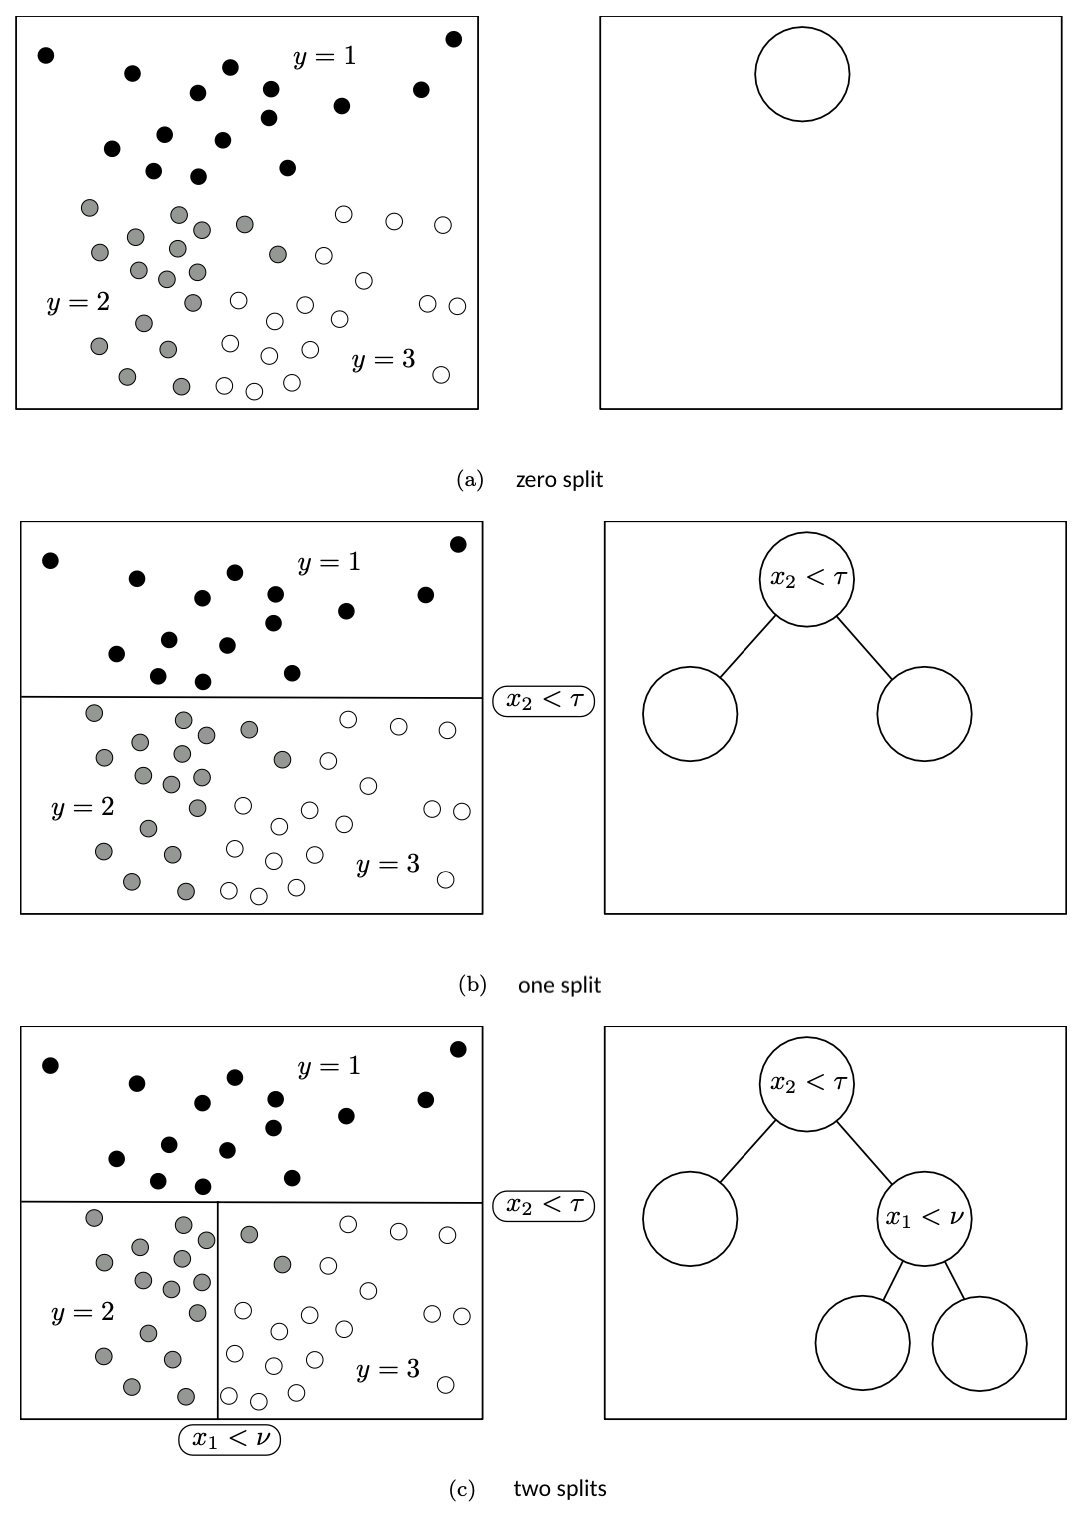

Ahora necesitamos definir una regla para decidir dónde dividir. Esta elección es crucial y no es única. Usamos una función para medir la "impureza", denotada por $H$, asociada a una partición. Buscamos la división (variable/umbral) que produzca la partición más pura según $H$. Matemáticamente, resolvemos:

$$
\arg\min_{j \in [ 1,p ],\; \tau \in \mathbb{R}} \widehat{q}_{j,\tau} H(G(j,\tau)) + (1 - \widehat{q}_{j,\tau}) H(D(j,\tau))
$$

donde:

$$
\widehat{q}_{j,\tau} =
\frac{|\{i \in [ 1,n ] : x_i \in I(j,\tau)\}|}
{|\{i' \in [ 1,n ] : x_{i'} \in I(j,\tau) \cup D(j,\tau)\}|}
$$

es la proporción de observaciones que caen en $I(j,\tau)$. Aquí, $|\cdot|$ denota la cardinalidad del conjunto.

Para cualquier conjunto $R \subset \mathbb{R}^p$ y etiqueta $k$, sea $\widehat{p}_k(R)$ la proporción de observaciones con etiqueta $k$ (indexadas de 1 a $K$):

$$
\widehat{p}_k(R) =
\frac{|\{i \in [ 1,n ] : x_i \in R \land y_i = k\}|}
{|\{i \in [ 1,n ] : x_i \in R\}|}
$$

CART considera las siguientes medidas de impureza $H$:

- Gini index: $\sum_{k=1}^K \widehat{p}_k(R)(1 - \widehat{p}_k(R))$
- Entropy: $-\sum_{k=1}^K \widehat{p}_k(R)\log(\widehat{p}_k(R))$

### Preguntas

1. Usa rand_checkers para simular muestras de tamaño $n=456$ (asegúrate de que las clases estén bien balanceadas). Crea una curva que muestre el porcentaje de accuracy de la clasificación en función de la profundidad máxima del árbol (rango 1 a 10). Utiliza entropia como criterio del split y no olvides usar un random_state.

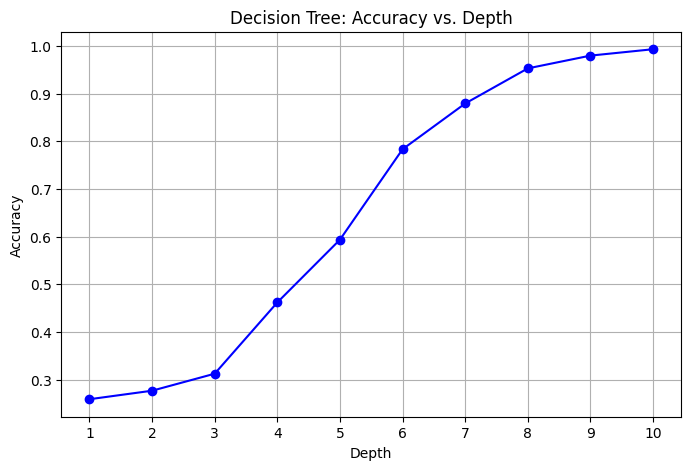

In [9]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

n = 456//4

d = rand_checkers(n, n, n, n, sigma=0.1)

X = d[:, :2]
y = d[:, 2]

depth = list(range(1,11))
acc = []

for d in depth:
    clf = DecisionTreeClassifier(criterion='entropy', max_depth=d, random_state=42)
    clf.fit(X,y)
    y_pred = clf.predict(X)
    accuracy = accuracy_score(y, y_pred)
    acc.append(accuracy)

plt.figure(figsize=(8, 5))
plt.plot(depth, acc, marker='o', linestyle='-', color='blue')
plt.title('Decision Tree: Accuracy vs. Depth')
plt.xlabel('Depth')
plt.ylabel('Accuracy')
plt.xticks(depth)
plt.grid(True)
plt.show()

2. Muestra la clasificación resultante usando la profundidad que minimiza el porcentaje de error con entropía (usa las funciones plot_2d y frontiere del archivo fuente).

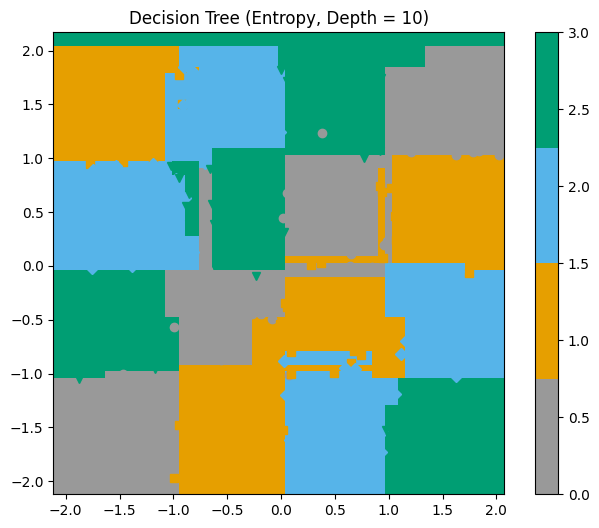

In [10]:
min_clf = DecisionTreeClassifier(criterion='entropy', max_depth=10, random_state=42)
min_clf.fit(X,y)

plt.figure(figsize=(8, 6))
frontiere(min_clf.predict, X, step=100)
plot_2d(X,y=y)
plt.title(f'Decision Tree (Entropy, Depth = {10})')
plt.show()

3. Vuelve a entrenar un árbol de decisión, pero con una profundidad máxima de 5. Luego genera un gráfico del árbol de decisión de la pregunta anterior. Hint: usar la función `plot_tree` del módulo `tree` de sklearn.

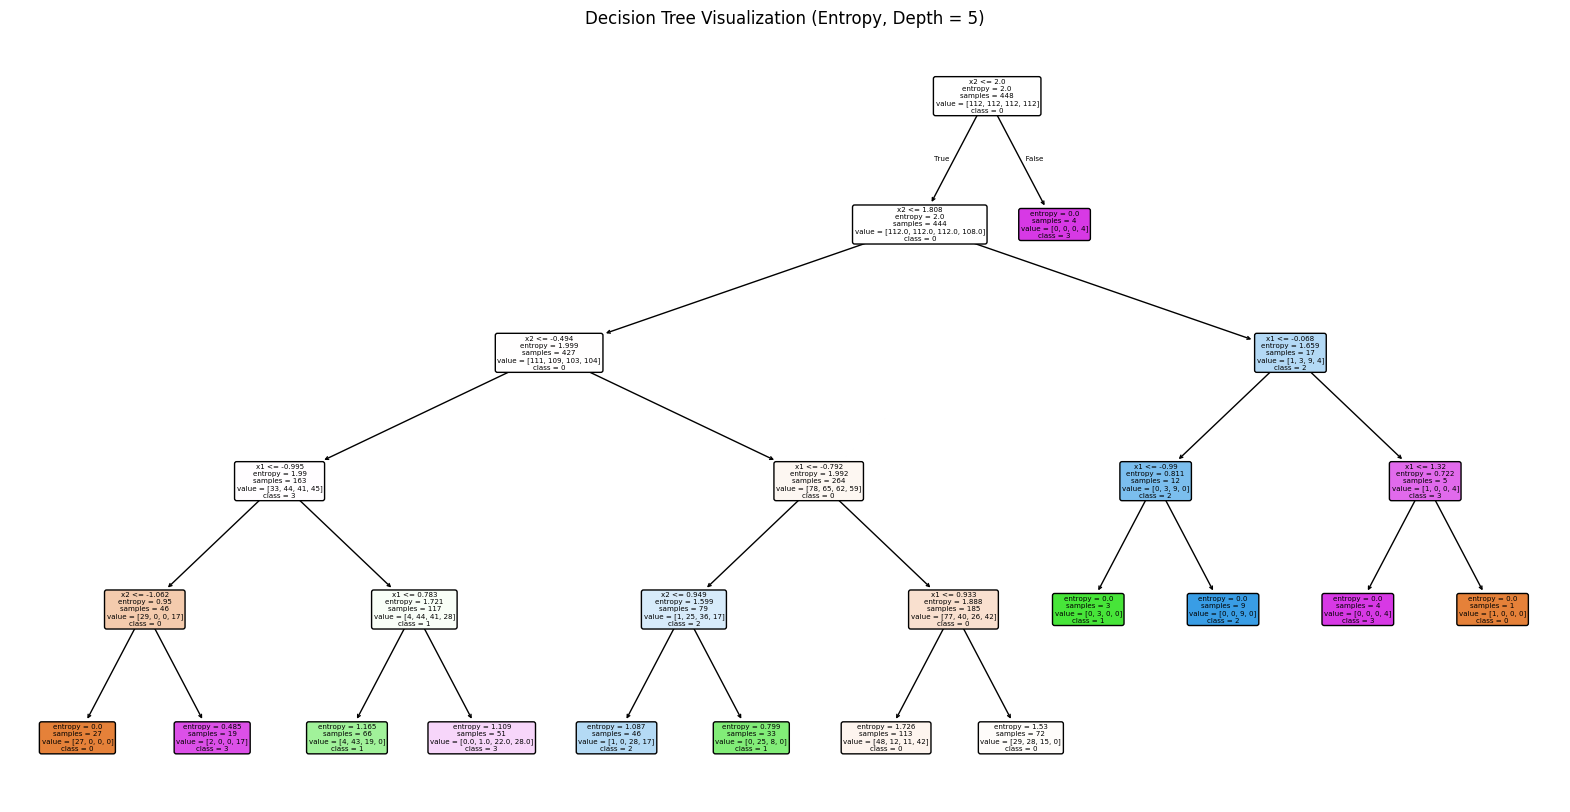

In [11]:
from sklearn.tree import plot_tree

clf2 = DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state=42)
clf2.fit(X,y)

plt.figure(figsize=(20, 10))
plot_tree(clf2,
          feature_names=["x1", "x2"],
          class_names=[str(int(cls)) for cls in np.unique(y)],
          filled=True,
          rounded=True)
plt.title("Decision Tree Visualization (Entropy, Depth = 5)")
plt.show()

4. Genera $n=160$ nuevos puntos de datos con rand_checkers. Para los árboles de decisión obtenidos en la pregunta 1, calcula el accuracy en esta segunda muestra. Comenta diferencias en la accuracy.

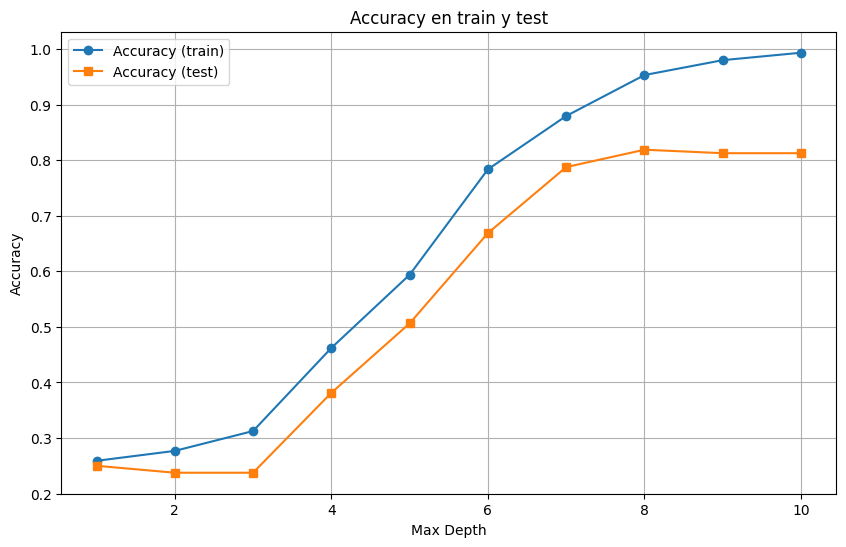

In [12]:
data_test = rand_checkers(40, 40, 40, 40, sigma=0.1)
X_test = data_test[:, :2]
Y_test = data_test[:, 2].astype(int)
dmax = range(1,11)

train_acc = []
test_acc = []

for d in dmax:
    clf3 = DecisionTreeClassifier(criterion='entropy', max_depth=d, random_state=42)
    clf3.fit(X, y)
    y_train_pred = clf3.predict(X)
    y_test_pred = clf3.predict(X_test)

    train_acc.append(accuracy_score(y, y_train_pred))
    test_acc.append(accuracy_score(Y_test, y_test_pred))

plt.figure(figsize=(10, 6))
plt.plot(dmax, train_acc, label="Accuracy (train)", marker='o')
plt.plot(dmax, test_acc, label="Accuracy (test)", marker='s')
plt.xlabel("Max Depth")
plt.ylabel("Accuracy")
plt.title("Accuracy en train y test")
plt.legend()
plt.grid(True)
plt.show()



Para test es menor ya que no solo son menos datos sino que fue entrenado con otra data por lo que no puede predecir bien, mas que nada puede generalizar, incluso con X pudo haber memorizado ruido causando overfitting como se puede intuir en la p1.

Pauta: comentar si varia el accuracy entre ambos experimentos. Deberia ser menor por que es en un conjunto de test y no en los mismos datos de entrenamiento.

5. Repite el experimento de la pregunta 1 para el conjunto de datos zipcode. Este conjunto está disponible en sklearn.datasets. Puedes cargarlo usando la función load_digits (o ver más en [http://scikit-learn.org/stable/auto_examples/classification/plot_digits_classification.html](http://scikit-learn.org/stable/auto_examples/classification/plot_digits_classification.html)):

```python
digits = datasets.load_digits()
 ```

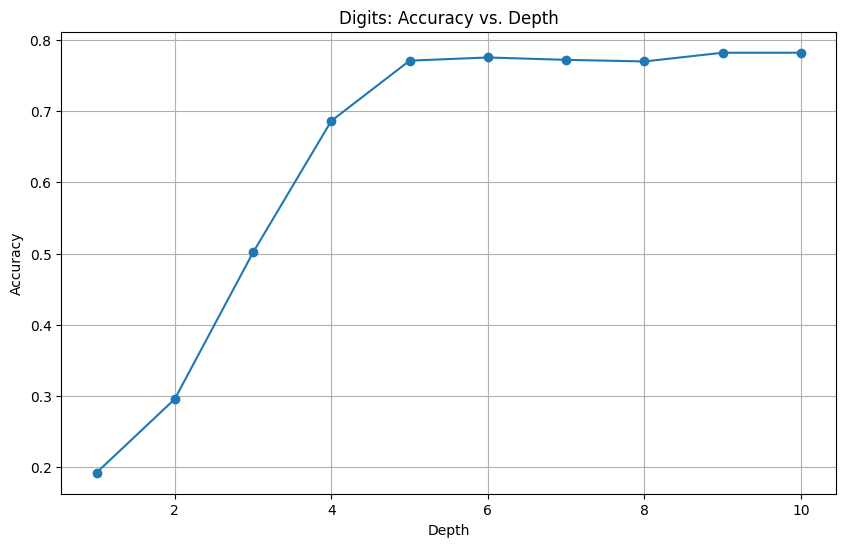

In [13]:
from sklearn import datasets
digits = datasets.load_digits()

n_samples = len(digits.data)
X = digits.data[:n_samples // 2]
Y = digits.target[:n_samples // 2]
X_test = digits.data[n_samples // 2:]
Y_test = digits.target[n_samples // 2:]

dmax = 10
scores = np.zeros(dmax)

for d in range(1, dmax+1):
    clf4 = DecisionTreeClassifier(criterion='entropy', max_depth=d, random_state=42)
    clf4.fit(X, Y)
    y_pred2 = clf4.predict(X_test)
    scores[d-1] = accuracy_score(Y_test, y_pred2)

plt.figure(figsize=(10, 6))
plt.plot(range(1, dmax + 1), scores, marker='o')
plt.title("Digits: Accuracy vs. Depth")
plt.xlabel("Depth")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()

No generaliza bien, mas bien se estanca debido a no captar relaciones complejas de 'digits' y el sobreajuste, por eso aumentar la profundidad no sirve de mucho.

#### Métodos de selección de parámetros - Selección de modelos

En la práctica, rara vez se dispone de un conjunto de prueba (preferimos incluir la mayor cantidad de datos en el conjunto de entrenamiento, pero en la parte anterior usamos solo la mitad). Para seleccionar un modelo o parámetro utilizando la mayor cantidad posible de ejemplos de entrenamiento, normalmente se usa la validación cruzada. Para cada parámetro, se obtiene una estimación del error empírico de la siguiente manera:

Dividir el conjunto de entrenamiento en $N$ subconjuntos de tamaño $n/N$

Para cada subconjunto, medir el error del clasificador (con el conjunto de parámetros fijado) entrenado con los otros $N-1$ subconjuntos

El error estimado es el promedio de los errores de todos los clasificadores entrenados

Esto se puede repetir sobre una malla de parámetros para obtener una estimación de error por parámetro, y luego elegir el parámetro que minimiza dicha estimación.

Para más detalles sobre las funcionalidades de validación cruzada en scikit-learn, consulta http://scikit-learn.org/stable/modules/cross_validation.html.

6. Usa la función `sklearn.model_selection.cross_val_score` y pruébala en el conjunto de datos zipcode variando la profundidad del árbol. Con esta función, determina la mejor profundidad máxima (puedes aumentar el rango) y la precisión promedio obtenida con ella.

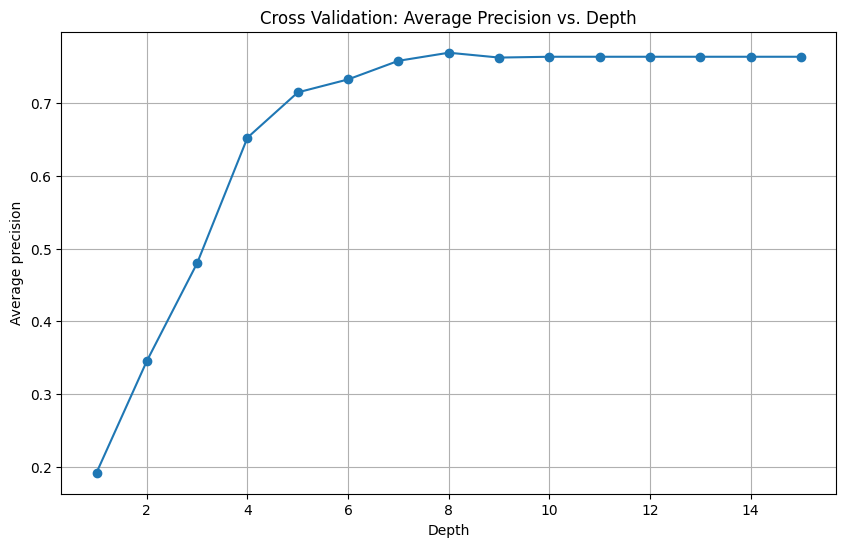

best depth: 8
best precision: 0.7694537554314091


In [14]:
from sklearn.model_selection import cross_val_score

dmax = 15 # Rango maximo a probar para profundidad
scores_cv = []

# TODO: guardar la precision promedio para cada profundidad
for d in range(1, dmax+1):
    clf5 = DecisionTreeClassifier(criterion='entropy', max_depth=d, random_state=42)
    cv_score = cross_val_score(clf5, X, Y, cv=5, scoring='accuracy')
    mean = np.mean(cv_score)
    scores_cv.append(mean)

scores_cv = np.array(scores_cv)

# TODO: graficar los resultados
plt.figure(figsize=(10, 6))
plt.plot(range(1, dmax + 1), scores_cv, marker='o')
plt.title("Cross Validation: Average Precision vs. Depth")
plt.xlabel("Depth")
plt.ylabel("Average precision")
plt.grid(True)
plt.show()

# TODO: imprimir la profundidad optima y la precision obtenida con ella
mejor_prof = np.argmax(scores_cv) + 1
mejor_prec = scores_cv[mejor_prof - 1]

print(f"best depth: {mejor_prof}")
print(f"best precision: {mejor_prec}")

Si bien es menor la precision promedio es lo que mejor percibe el punto optimo que en este caso vendria siendo 8 dado que despues suele estancarse. Contrasta que este metodo sacrifique precision por estabilidad a diferencia del anterior.

## Bagging de Árboles de decisión: Random Forests

Bagging (abreviación de "Bootstrap Aggregation"; Breiman et al. 96) es un método clásico para ponderar modelos. Consiste simplemente en promediar las predicciones con $w_l = 1/L$. Para generar datos de entrenamiento aleatorios, utiliza muestreo bootstrap. Una muestra bootstrap es una muestra de $n$ puntos de entrenamiento extraídos de $\mathcal{D}$ mediante muestreo aleatorio con reemplazo.

### Funcionamiento

Consideremos el problema estándar de aprendizaje supervisado. Dado un conjunto de entrenamiento $\mathcal{D} = {(X_1, Y_1), \dots, (X_n, Y_n)}$ generado por una función desconocida $f$, donde $Y = f(X)$, un algoritmo de aprendizaje estima $\hat{f}_\mathcal{D}$, que es el modelo estimado. Si los valores $Y_i$ están en ${1, \dots, K}$, tenemos un problema de clasificación con $K$ clases; si los valores $Y_i$ están en $\mathbb{R}$, es un problema de regresión.

Una agregación de modelos (clasificadores/estimadores) se obtiene mediante una combinación (lineal) de las predicciones individuales de cada modelo. En regresión, el modelo agregado $\hat{F}\mathcal{D}^L$ se obtiene a partir de $L$ clasificadores/estimadores $\hat{f}\mathcal{D}^l,; l = 1,\dots,L$ de la siguiente forma:

$$ \hat{F}_\mathcal{D}^L(X) = \sum_{l=1}^{L} w_l \hat{f}_\mathcal{D}^l(X)$$

donde $w_l \geq 0$ son los pesos.

En clasificación, la agregación puede hacerse mediante votación (devolviendo la clase predicha por la mayoría de los estimadores), promediando las probabilidades de clase o promediando el margen.
Si un clasificador binario $\hat{f}\mathcal{D}^l$ predice $X$ usando el signo de $\hat{f}\mathcal{D}^l(X)$, el modelo agregado usa el signo de $\sum_{l=1}^{L} w_l \hat{f}_\mathcal{D}^l(X)$.

Una condición necesaria y suficiente para que el modelo agregado sea más preciso que cada modelo individual es que cada uno tenga un rendimiento mejor que el azar y que hagan predicciones distintas cuando se entrenan con diferentes datos.
La idea central de la agregación es que promediar las predicciones de múltiples modelos independientes reduce la varianza y, por lo tanto, el error de predicción.

### Regresor

7. Escriba un script que implemente el método `Bagging` utilizando árboles de decisión de profundidad 1 (también llamados stumps) y, posteriormente, árboles más profundos. Utilice el código a continuación como punto de partida. Puede usar  `np.random.randint` para generar muestras de bootstrap.

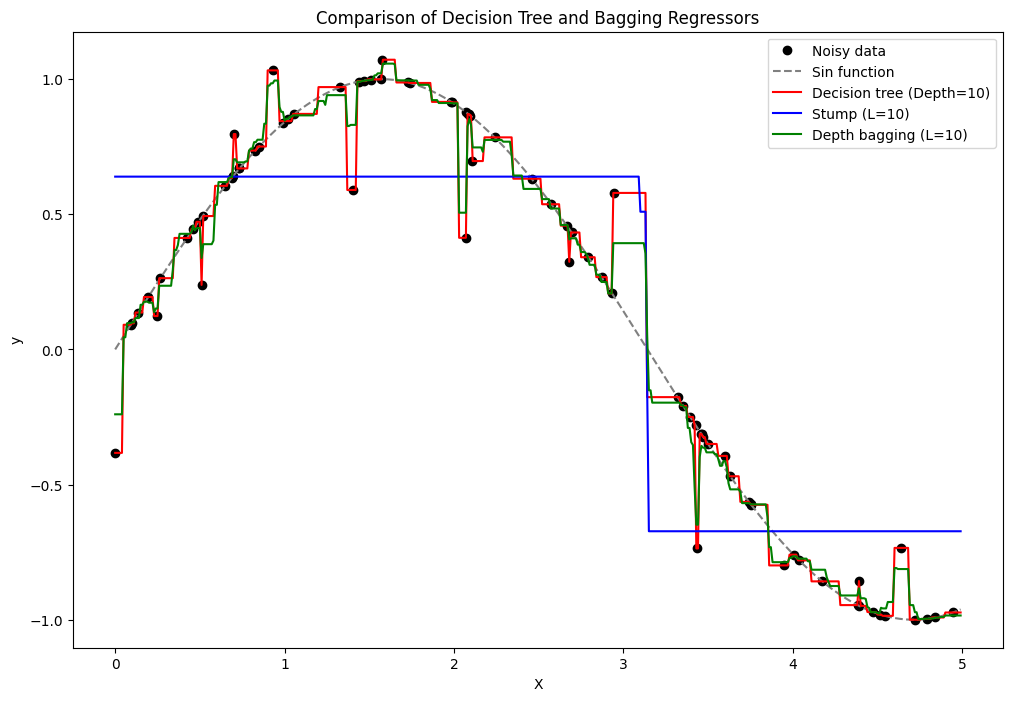

In [15]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor

rng = np.random.RandomState(1)
X = np.sort(5 * rng.rand(80, 1), axis=0) 
y = np.sin(X).ravel() 
noise_level = 1
y[::5] += (0.5 - rng.rand(16)) * noise_level 

n_estimators = 10 # L
tree_max_depth = 10
bagging_max_depth = 100

# decision tree
tree = DecisionTreeRegressor(max_depth=tree_max_depth, random_state=rng)
tree.fit(X, y)

# stump
bagging_stumps = BaggingRegressor(
    estimator=DecisionTreeRegressor(max_depth=1),
    n_estimators=n_estimators,
    random_state=rng
)
bagging_stumps.fit(X, y)

# depth bagging
bagging_deep = BaggingRegressor(
    estimator=DecisionTreeRegressor(max_depth=bagging_max_depth),
    n_estimators=n_estimators,
    random_state=rng
)
bagging_deep.fit(X, y)

X_test = np.arange(0.0, 5.0, 0.01)[:, np.newaxis]
y_tree = tree.predict(X_test)
y_bagging_stumps = bagging_stumps.predict(X_test)
y_bagging_deep = bagging_deep.predict(X_test)

plt.figure(figsize=(12, 8))
plt.plot(X, y, 'o', c="k", label="Noisy data")
plt.plot(X_test, np.sin(X_test), '--', c="gray", label="Sin function")
plt.plot(X_test, y_tree, '-', c="red", label=f"Decision tree (Depth={tree_max_depth})")
plt.plot(X_test, y_bagging_stumps, '-', c="blue", label=f"Stump (L={n_estimators})")
plt.plot(X_test, y_bagging_deep, '-', c="green", label=f"Depth bagging (L={n_estimators})")
plt.xlabel("X")
plt.ylabel("y")
plt.title("Comparison of Decision Tree and Bagging Regressors")
plt.legend()
plt.show()

* Observe el efecto de $L$ y la profundidad del árbol (`max_depth`).
* ¿Cómo puede determinar que los estimadores basados en árboles están sesgados y que el bagging reduce su varianza?
* Experimentando con el nivel de ruido, resalte el overfitting. ¿Cómo se ve en el gráfico?

> **Respuesta:** Mas profundidad es mas riesgo de overfitting y se ajusta mas a la funcion del seno. Mas grande L menos varianza hay suavizando predicciones. Para saber si estan sesgados hay que ver que tantos se ajustan al modelo y para ver como el bagging reduce varianza es que tan sensible es al ruido pero como entrena tantas veces suaviza cambios (ver como la linea verde no se acerca tanto al puntos ruidosos). Sobre el ruido es notorio que los arboles profundos y de decision consideran estas variables ruidosas las cual memorizan causando overfitting a ruido alto, en cambio cuando es bajo se asimila mas a la realidad.

### Clasificador

Ahora, probemos con clasificadores.

8. Observa la decisión de frontera entre un árbol de decisión y un random forest. ¿Qué se puede decir sobre la generalización de la predicción del DT único y del conjunto? Usa la clase `BaggingClassifier`.

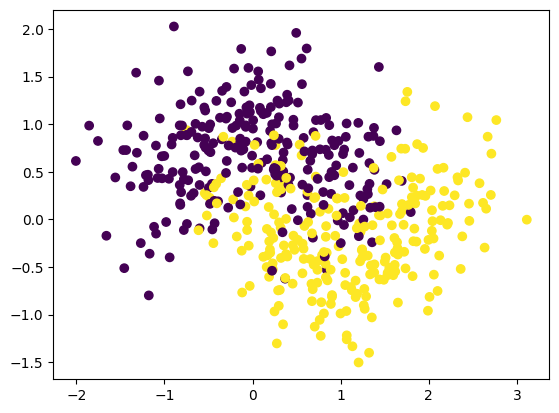

In [16]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

X, y = make_moons(n_samples=500, noise=0.4, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
plt.scatter(X[:, 0], X[:, 1], c=y)

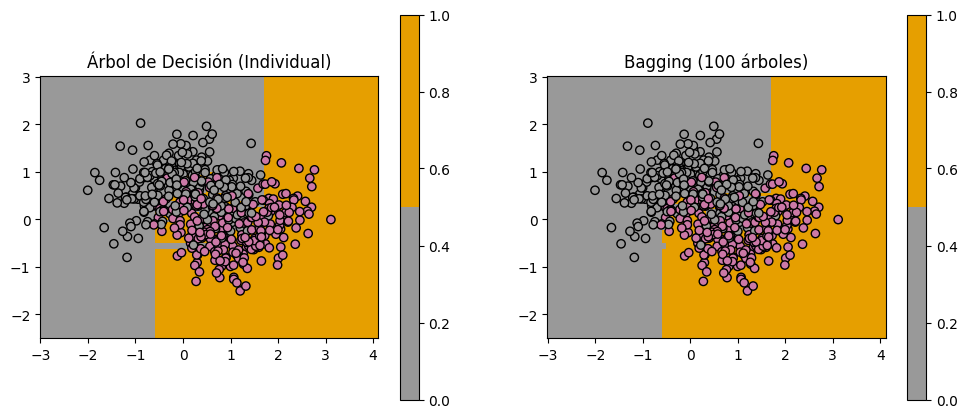

In [17]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier


# decision tree
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)

# bagging
bagging = BaggingClassifier(
    DecisionTreeClassifier(random_state=42),
    n_estimators=100,
    random_state=42
)
bagging.fit(X_train, y_train)

def plot_decision_boundary(clf, X, y, title):
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                     np.arange(y_min, y_max, 0.02))
    
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    plt.contourf(xx, yy, Z, alpha=0.4)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k')
    plt.title(title)

# plot
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
frontiere(dt.predict, X, step=100)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=colors.ListedColormap(collist), edgecolors='k')
plt.title("Árbol de Decisión (Individual)")

plt.subplot(1, 2, 2)
frontiere(bagging.predict, X, step=100)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=colors.ListedColormap(collist), edgecolors='k')
plt.title("Bagging (100 árboles)")

plt.show()

9. Compare los scores de 5-fold cross-validation de random forest y arboles de decisión (utilizando `DecisionTreeClassifier`). Varíe el parámetro `max_depth` de 1 a 30. Note cómo random forest ayuda a reducir el overfitting incluso con árboles profundos.
> Nota: Random Forest es un modelo basado en Bagging, que agrega randomización adicional en el proceso de split de los árboles

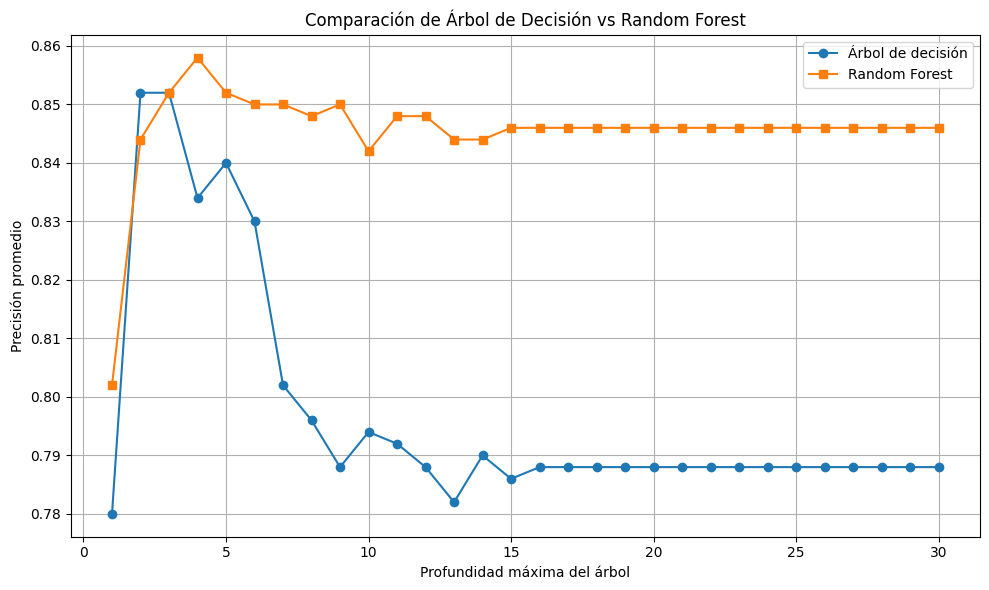

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

# TODO: Entrenar los modelos con cross-validation variando max_depth
#       y guardar la precision promedio

rt = DecisionTreeClassifier(random_state=0)
rf = RandomForestClassifier(random_state=0)

depths = range(1, 31)
scores_rt = np.zeros(len(depths))
scores_rf = np.zeros(len(depths))

for i in depths:
    rt.set_params(max_depth=i)
    rf.set_params(max_depth=i)
    scores_rt[i - 1] = cross_val_score(rt, X, y, cv=5).mean()
    scores_rf[i - 1] = cross_val_score(rf, X, y, cv=5).mean()

# TODO: graficar los resultados
plt.figure(figsize=(10, 6))
plt.plot(depths, scores_rt, label='Árbol de decisión', marker='o')
plt.plot(depths, scores_rf, label='Random Forest', marker='s')
plt.xlabel('Profundidad máxima del árbol')
plt.ylabel('Precisión promedio')
plt.title('Comparación de Árbol de Decisión vs Random Forest')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()